In [46]:
import pandas as pd
import numpy as np
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
from SMT_Data_Starter_2025 import readDataSubset
import matplotlib.pyplot as plt
from IPython.display import HTML
import great_tables as gt

In [47]:
# Just get the subsets out of the way
game_info_subset = readDataSubset('game_info')
game_events_subset = readDataSubset('game_events')
player_position_subset = readDataSubset('player_pos')
ball_position_subset = readDataSubset('ball_pos')

## Here's how we're going to go about this
1. Get every throw event (& get transition time)
   (Note: This might be wrong because the next event_code might just be ball_bounce or deflection, etc.)

(((2. Get momentum info for each throw)))

3. Attribute each throw with player_id 

4. Estimate velocities across each throw
   (Note: should we adjust for the slow-down?)

   Estimate momentum across each throw

5. Estimate max.velocities (i.e. "the" velo) of each throw

6. Make some charts

In [48]:
"""
Get every throw event (& get transition time)
"""
every_throw = game_events_subset.to_table(
    # filter = pads.field('event_code') == 3, # We're not filtering here to get the next timestamp (to isolate just the throw)
    columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']
).to_pandas()
# Make sure it's sorted
every_throw = every_throw.sort_values(by=["game_str","play_id","timestamp"])

# Get transition_time
#   (See Appendix: every single game_event preceding a throw is ball_acquired)
# groupby with game_str and play_id makes sure game_str and play_id are the same for both event_code
every_throw['acq_time'] = every_throw.groupby(
    ['game_str','play_id'])['timestamp'].shift(1).astype('Int64')
every_throw['transition_ms'] = every_throw['timestamp'] - every_throw['acq_time']

# Get end_time (this is when the ball is caught)
# We will get this by using the timestamp of the next event_code with the same play_id
#   (This might be wrong because the next event_code might just be ball_bounce or deflection, etc.)
#   (See Appendix)
every_throw['end_time'] = every_throw.groupby(
    ['game_str','play_id'])['timestamp'].shift(-1).astype('Int64')

# Filter for throws
# We're excluding unknown field positions
every_throw = every_throw[(every_throw['event_code'] == 3)]
# We will merge transition_times later (estimating max. velocity)
transition_times = every_throw[['game_str','play_id','player_position','transition_ms']]

# Rename timetamp to start_time (this is when the ball is thrown)
every_throw = every_throw.rename(columns={"timestamp":"start_time"})

In [49]:
# We're including ball_acquired
# (This becomes useful later on for adjusting ball position)
every_acq = game_events_subset.to_table(
    columns = ['game_str','play_id','play_per_game','timestamp','player_position','event_code']
).to_pandas()
every_acq = every_acq.sort_values(by=["game_str","play_id","timestamp"])
# (It should have a different logic for acq_time, start_time, end_time)
every_acq = every_acq.rename(columns={"timestamp":"acq_time"})
every_acq['start_time'] = every_acq.groupby(
    ['game_str','play_id'])['acq_time'].shift(-1).astype('Int64')
every_acq['transition_ms'] = every_acq['start_time'] - every_acq['acq_time']
every_acq['end_time'] = every_acq.groupby(
    ['game_str','play_id'])['acq_time'].shift(-2).astype('Int64')
# Checked for matching every_throw (code deleted for brevity)

every_acq = every_acq[(every_acq['event_code'] == 2)]

# Concatenate into every_throw
every_throw = pd.concat([every_throw, every_acq])
every_throw = every_throw.sort_values(by=["game_str","play_id","start_time"]) # Keep it sorted

print("Number of acquired:", len(every_throw[every_throw['event_code']==2]))
print("Number of throws:", len(every_throw[every_throw['event_code']==3]))
every_throw.iloc[5:15].T

Number of acquired: 76023
Number of throws: 10331


,8941,8940,8942,8945,8948,8951,8954,8957,8960,8963
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,4,4,4,5,6,7,8,9,10,11
play_per_game,4,4,4,5,6,7,8,9,10,11
start_time,88399,88399,89699,122899,148849,171399,196549,218049,257149,276749
player_position,7,7,6,2,2,2,2,2,2,2
event_code,3,2,2,2,2,2,2,2,2,2
acq_time,86799,86799,89699,122899,148849,171399,196549,218049,257149,276749
transition_ms,1600,1600,0,0,0,0,0,0,0,0
end_time,89699,89699,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [50]:
"""
Get momentum info for each throw
"""
player_pos = player_position_subset.to_table(
    columns = ["game_str","play_id","timestamp","player_position","field_x","field_y"]
).to_pandas()
# Recall that every_throw has the list of all throws
# Filter player_pos by game_str, play_id, player_position from every_throw
every_throw_list = every_throw[['game_str','play_id','player_position','acq_time','end_time']]
every_throw_pos = pd.merge(every_throw_list, player_pos, how="left", on=['game_str','play_id','player_position'])
# Only timestamps between ball acquisition & ball throw
every_throw_pos = every_throw_pos[(every_throw_pos['timestamp'] >= every_throw_pos['acq_time']) &
                                  (every_throw_pos['timestamp'] <= every_throw_pos['end_time'])]

# Estimate momentum (i.e. velocity) using distance / time (& direction)
# Doing .groupby(["game_str","play_id","event_code"]) makes it only look at
#   the block with the same game_str, play_id, player_position
every_throw_pos['prev_field_x'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['field_x'].shift(1)
every_throw_pos['prev_field_y'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['field_y'].shift(1)
every_throw_pos['prev_timestamp'] = every_throw_pos.groupby(
    ['game_str','play_id','player_position'])['timestamp'].shift(1).astype('Int64')

every_throw_pos['distance_x'] = every_throw_pos['field_x'] - every_throw_pos['prev_field_x']
every_throw_pos['distance_y'] = every_throw_pos['field_y'] - every_throw_pos['prev_field_y']
# (Apply (t\ \cdot\cos(momentum_angle_rad),\ t\cdot\sin(momentum_angle_rad)) on Desmos)
# (Then use Quick Visualization in Appendix to make sure angle is correct)
every_throw_pos['momentum_angle_rad'] = np.arctan2(every_throw_pos['distance_x'], every_throw_pos['distance_y'])
every_throw_pos['distance'] = np.sqrt((every_throw_pos['distance_x'])**2 +
                                      (every_throw_pos['distance_y'])**2 )
every_throw_pos['delta_time_ms'] = every_throw_pos['timestamp'] - every_throw_pos['prev_timestamp']
every_throw_pos['momentum_speed_fps'] = every_throw_pos['distance'] / (every_throw_pos['delta_time_ms']/1000)

every_throw_pos = every_throw_pos.drop(columns=["prev_field_x","prev_field_y","prev_timestamp",
                              "distance_x","distance_y","distance","delta_time_ms"])
# Make sure timestamp integer
every_throw_pos['timestamp'] = every_throw_pos['timestamp'].astype('Int64')

# Delete duplicates
print(len(every_throw_pos))
every_throw_pos = every_throw_pos.drop_duplicates(subset=[
    "game_str","play_id","player_position","acq_time","end_time","timestamp"
], keep='first').reset_index(drop=True) 
print("len(every_throw_pos) (acq_time to end_time):", len(every_throw_pos))

every_throw_pos.head(5)

# We will calculate
# 'Momentum in direction to target'
# later; We need to get target data from ball_pos

1120597
len(every_throw_pos) (acq_time to end_time): 560569


,game_str,play_id,player_position,acq_time,end_time,timestamp,field_x,field_y,momentum_angle_rad,momentum_speed_fps
0,y1_d001_CGA_QEA,2,9,29299,32799,29299,44.2860,253.5777,NaN,<NA>
1,y1_d001_CGA_QEA,2,9,29299,32799,29349,43.8729,253.1124,-2.415551,12.444367
2,y1_d001_CGA_QEA,2,9,29299,32799,29399,43.4802,252.6357,-2.452514,12.352428
3,y1_d001_CGA_QEA,2,9,29299,32799,29449,43.1073,252.1488,-2.488015,12.265823
4,y1_d001_CGA_QEA,2,9,29299,32799,29499,42.7539,251.6526,-2.522717,12.183694


In [51]:
"""
Attribute each throw with player_id
"""
game_info = game_info_subset.to_table().to_pandas()
every_throw_info = pd.merge(every_throw, game_info, how="inner", on = ['game_str','play_per_game'])
conditions = [
    every_throw_info['player_position'] == 1,    every_throw_info['player_position'] == 2,
    every_throw_info['player_position'] == 3,    every_throw_info['player_position'] == 4,
    every_throw_info['player_position'] == 5,    every_throw_info['player_position'] == 6,
    every_throw_info['player_position'] == 7,    every_throw_info['player_position'] == 8,
    every_throw_info['player_position'] == 9,    every_throw_info['player_position'] == 10,
    every_throw_info['player_position'] == 11,    every_throw_info['player_position'] == 12,
    every_throw_info['player_position'] == 13,    every_throw_info['player_position'] == 14,
    every_throw_info['player_position'] == 15,    every_throw_info['player_position'] == 16,
    every_throw_info['player_position'] == 17,    every_throw_info['player_position'] == 18,
    every_throw_info['player_position'] == 19,    every_throw_info['player_position'] == 255
]
choices = [
    every_throw_info['pitcher'],    every_throw_info['catcher'],
    every_throw_info['first_base'],    every_throw_info['second_base'],
    every_throw_info['third_base'],    every_throw_info['shortstop'],
    every_throw_info['left_field'],    every_throw_info['center_field'],
    every_throw_info['right_field'],    every_throw_info['batter'],
    every_throw_info['first_baserunner'],    every_throw_info['second_baserunner'],
    every_throw_info['third_baserunner'],    "Umpire",
    "Umpire",    "Umpire",
    "Umpire",    "Coach",
    "Coach",    "Ball-event-with-no-player"
]
# throw_id is player_id of the thrower
every_throw_info['thrower_id'] = np.select(conditions, choices, default=None)
# Rid unused columns
every_throw_info = every_throw_info.drop(columns=['pitcher','catcher','first_base','second_base',
                                        'third_base','shortstop','left_field',
                                        'center_field','right_field','batter',
                                        'first_baserunner','second_baserunner',
                                        'third_baserunner','year','day',
                                        'home_team','away_team','top_bottom_inning','at_bat'])

print("Number of acquired (updated):", len(every_throw_info[every_throw_info['event_code']==2]))
print("Number of throws (updated):", len(every_throw_info[every_throw_info['event_code']==3]))
every_throw_info.head(5).T

Number of acquired (updated): 69108
Number of throws (updated): 9298


,0,1,2,3,4
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,1,2,2,2,3
play_per_game,1,2,2,2,3
start_time,9199,31649,31649,33599,63199
player_position,2,9,9,4,2
event_code,2,3,2,2,2
acq_time,9199,29299,29299,32799,63199
transition_ms,0,2350,2350,800,0
end_time,<NA>,32799,32799,<NA>,<NA>
thrower_id,QEA-0071,QEA-0252,QEA-0252,QEA-0365,QEA-0071


In [52]:
"""
Ball position adjustment
"""
# Attribute all ball_pos to throws
ball_pos = ball_position_subset.to_table(
    columns = ['game_str','play_id','timestamp','ball_position_x','ball_position_y','ball_position_z']).to_pandas()
every_throw_tracking = pd.merge(every_throw_info, ball_pos, how="left", on=["game_str","play_id"])
every_throw_tracking['timestamp'] = every_throw_tracking['timestamp'].astype('Int64')
every_throw_tracking = every_throw_tracking[(every_throw_tracking['timestamp'] >= every_throw_tracking['acq_time']) & 
                                          (every_throw_tracking['timestamp'] <= every_throw_tracking['end_time'])]
every_throw_tracking.iloc[100:110].T


print("len(every_throw_pos): ", len(every_throw_pos))
print("len(every_throw_tracking): ", len(every_throw_tracking))
# Fill all rows with play_per_game/start_time/event_code/transition_ms where NA
# (See below; NA happens where ball not tracked)
temp_df = every_throw_tracking.drop(columns=['ball_position_x','ball_position_y','ball_position_z','timestamp'])
temp_df = temp_df.drop_duplicates()
every_throw_withpos = pd.merge(every_throw_pos, temp_df, 
                               how="left", on=["game_str","play_id","player_position",
                                               "acq_time","end_time"])
print("(After fill) len(every_throw_withpos): ", len(every_throw_withpos))
# Join all ball_pos with player position(momentum)
every_throw_withpos = pd.merge(every_throw_withpos, every_throw_tracking, 
                               how="left", on=["game_str","play_id","player_position","play_per_game","thrower_id",
                                               "transition_ms","event_code","acq_time","start_time","end_time","timestamp"])
every_throw_withpos = every_throw_withpos.sort_values(by=["game_str","play_id","timestamp"]) 
print("(Fillx2) len(every_throw_withpos): ", len(every_throw_withpos))
# Drop duplicates (wrong event_codes)
drop_mask = (
    ((every_throw_withpos['timestamp'] >= every_throw_withpos['start_time']) & (every_throw_withpos['event_code'] == 2)) |
    ((every_throw_withpos['timestamp'] <  every_throw_withpos['start_time']) & (every_throw_withpos['event_code'] == 3)))
every_throw_withpos = every_throw_withpos[~drop_mask]
print("(After dropping) len(every_throw_withpos): ", len(every_throw_withpos))
every_throw_withpos.iloc[100:130].T


# # See Appendix; camera can't track ball when it's in the player's hand
# print("Number of acquired (pos datapoints):", 
#       len(every_throw_withpos[(every_throw_withpos['timestamp'] >= every_throw_withpos['acq_time']) & 
#                               (every_throw_withpos['timestamp'] < every_throw_withpos['start_time'])]))
# print("Number of throws (pos datapoints):", 
#       len(every_throw_withpos[(every_throw_withpos['timestamp'] >= every_throw_withpos['start_time']) & 
#                               (every_throw_withpos['timestamp'] < every_throw_withpos['end_time'])]))
# print("Number of acquired (ball datapoints):", len(every_throw_withpos[every_throw_withpos['event_code']==2]))
# print("Number of throws (ball datapoints):", len(every_throw_withpos[every_throw_withpos['event_code']==3]))


# Use latest ball position 
# Calculate distance from center of mass
# Then scale the distance to be max. 3ft from body (player_pos)
every_throw_withpos["latest_ball_pos_x"] = every_throw_withpos.groupby("acq_time")["ball_position_x"].ffill()
every_throw_withpos["latest_ball_pos_y"] = every_throw_withpos.groupby("acq_time")["ball_position_y"].ffill()
every_throw_withpos["latest_ball_pos_z"] = every_throw_withpos.groupby("acq_time")["ball_position_z"].ffill()

every_throw_withpos['ball_x_frombody'] = every_throw_withpos['latest_ball_pos_x'] - every_throw_withpos['field_x']
every_throw_withpos['ball_y_frombody'] = every_throw_withpos['latest_ball_pos_y'] - every_throw_withpos['field_y']
every_throw_withpos['ball_dist_frombody'] = np.sqrt(every_throw_withpos['ball_x_frombody']**2 +
                                                     every_throw_withpos['ball_y_frombody']**2)
every_throw_withpos['ball_dist_scalefactor'] = np.minimum(3 / every_throw_withpos['ball_dist_frombody'], 1)
every_throw_withpos['ball_x_frombody_scaled'] = every_throw_withpos['ball_x_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_y_frombody_scaled'] = every_throw_withpos['ball_y_frombody'] * every_throw_withpos['ball_dist_scalefactor']
every_throw_withpos['ball_pos_x_adj'] = every_throw_withpos['field_x'] + every_throw_withpos['ball_x_frombody_scaled']
every_throw_withpos['ball_pos_y_adj'] = every_throw_withpos['field_y'] + every_throw_withpos['ball_y_frombody_scaled']
every_throw_withpos['ball_pos_z_adj'] = every_throw_withpos["latest_ball_pos_z"] # No change for z

# Don't scale after ball leaves body (i.e. 1 timestamp after event_code turns 3)
mask = (every_throw_withpos['event_code'] == 3) & (every_throw_withpos['event_code'].shift(1) == 3)
every_throw_withpos.loc[mask, 'ball_pos_x_adj'] = every_throw_withpos.loc[mask, 'ball_position_x']
every_throw_withpos.loc[mask, 'ball_pos_y_adj'] = every_throw_withpos.loc[mask, 'ball_position_y']

every_throw_withpos[every_throw_withpos['event_code']==2].iloc[160:190].T

len(every_throw_pos):  560569
len(every_throw_tracking):  531987
(After fill) len(every_throw_withpos):  1058014
(Fillx2) len(every_throw_withpos):  1060158
(After dropping) len(every_throw_withpos):  561548


,635,637,639,641,643,645,647,677,679,681,...,703,705,707,709,711,713,715,717,719,721
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,...,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,26,26,26,26,26,26,26,28,28,28,...,28,28,28,28,28,28,28,28,28,28
player_position,2,2,2,2,2,2,2,8,8,8,...,8,8,8,8,8,8,8,8,8,8
acq_time,718549,718549,718549,718549,718549,718549,718549,893699,893699,893699,...,893699,893699,893699,893699,893699,893699,893699,893699,893699,893699
end_time,719949,719949,719949,719949,719949,719949,719949,897199,897199,897199,...,897199,897199,897199,897199,897199,897199,897199,897199,897199,897199
timestamp,718949,718999,719049,719099,719149,719199,719249,893699,893749,893799,...,894349,894399,894449,894499,894549,894599,894649,894699,894749,894799
field_x,0.5025,0.8238,1.1448,1.4658,1.7868,2.1078,2.4291,-27.084,-27.2991,-27.5106,...,-29.4504,-29.5806,-29.7024,-29.8155,-29.9199,-30.0162,-30.1044,-30.1845,-30.2568,-30.3216
field_y,30.5805,30.8046,31.0287,31.2531,31.4772,31.7013,31.9254,270.5316,270.1632,269.8005,...,266.1309,265.8231,265.5201,265.2216,264.9285,264.6411,264.3597,264.0852,263.8182,263.5599
momentum_angle_rad,0.960698,0.961764,0.961326,0.960698,0.961326,0.961326,0.961764,NaN,-2.613113,-2.613673,...,-2.723457,-2.741416,-2.75938,-2.779412,-2.799412,-2.818277,-2.837858,-2.857673,-2.877148,-2.895794
momentum_speed_fps,7.833169,7.834654,7.829733,7.833169,7.829733,7.829733,7.834654,<NA>,8.531977,8.397227,...,6.841402,6.684097,6.531286,6.384164,6.222764,6.062094,5.897973,5.71896,5.532316,5.326084


In [53]:
# Quick Visualization

# game_str = "y1_d001_CGA_QEA"
# play_id = 2

# player_position_df = player_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()
# ball_position_df = every_throw_withpos[every_throw_withpos['game_str'] == game_str]
# ball_position_df = ball_position_df[['game_str','play_id','timestamp','ball_pos_x_adj','ball_pos_y_adj','ball_pos_z_adj']]
# ball_position_df = ball_position_df.rename(columns={"ball_pos_x_adj":"ball_position_x",
#                                                     "ball_pos_y_adj":"ball_position_y",
#                                                     "ball_pos_z_adj":"ball_position_z"})
# temp_df = ball_position_subset.to_table(filter = (pads.field('game_str') == game_str)).to_pandas()

# keys = ['game_str', 'play_id', 'timestamp']
# existing_keys = set(ball_position_df[keys].apply(tuple, axis=1))
# df2_no_dupes = temp_df[~temp_df[keys].apply(tuple, axis=1).isin(existing_keys)]
# result = pd.concat([ball_position_df, df2_no_dupes], ignore_index=True)


# from Animation import plot_animation
# plot_animation(player_position_df, result, play_id, save_gif=False)

In [54]:
"""
Estimate velocities across each throw.
We'll do this by distance ÷ time across 1 time interval (2 timestamps)
Keep in mind we're using adjusted ball positions now
"""
# Estimate velocity at previous interval
every_throw_withpos['prev_ball_pos_x_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_x_adj"].shift(1)
every_throw_withpos['prev_ball_pos_y_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_y_adj"].shift(1)
every_throw_withpos['prev_ball_pos_z_adj'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["ball_pos_z_adj"].shift(1)
every_throw_withpos['prev_timestamp'] = every_throw_withpos.groupby(
    ["game_str","play_id","event_code"])["timestamp"].shift(1)

# Get displacements
every_throw_withpos['ball_displacement_x'] = every_throw_withpos['ball_pos_x_adj'] - every_throw_withpos['prev_ball_pos_x_adj']
every_throw_withpos['ball_displacement_y'] = every_throw_withpos['ball_pos_y_adj'] - every_throw_withpos['prev_ball_pos_y_adj']
every_throw_withpos['ball_displacement_z'] = every_throw_withpos['ball_pos_z_adj'] - every_throw_withpos['prev_ball_pos_z_adj']
every_throw_withpos['ball_rad_xy'] = np.arctan2(every_throw_withpos['ball_displacement_x'],every_throw_withpos['ball_displacement_y'])
every_throw_withpos['ball_distance'] = np.sqrt(every_throw_withpos['ball_displacement_x']**2 + 
                                           every_throw_withpos['ball_displacement_y']**2 + 
                                           every_throw_withpos['ball_displacement_z']**2)

# Timestamps are in ms; ÷1000 to get s
every_throw_withpos['prev_interval_length_ms'] = every_throw_withpos['timestamp'] - every_throw_withpos['prev_timestamp']
every_throw_withpos['prev_interval_ballspeed'] = every_throw_withpos['ball_distance'] / (every_throw_withpos['prev_interval_length_ms']/1000)  # ft/s

# Drop used columns
every_throw_withpos = every_throw_withpos.drop(
    columns=["prev_ball_pos_x_adj","prev_ball_pos_y_adj","prev_ball_pos_z_adj",
             "ball_displacement_x","ball_displacement_y","ball_displacement_z",
             "ball_x_frombody","ball_y_frombody","ball_dist_frombody","ball_dist_scalefactor",
             "ball_x_frombody_scaled","ball_y_frombody_scaled",
             # We're not using ball_position_xyz from now on
             "ball_position_x","ball_position_y","ball_position_z"])

every_throw_withpos.head(5).T

,1,3,5,7,9
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,2,2,2,2,2
player_position,9,9,9,9,9
acq_time,29299,29299,29299,29299,29299
end_time,32799,32799,32799,32799,32799
timestamp,29299,29349,29399,29449,29499
field_x,44.286,43.8729,43.4802,43.1073,42.7539
field_y,253.5777,253.1124,252.6357,252.1488,251.6526
momentum_angle_rad,NaN,-2.415551,-2.452514,-2.488015,-2.522717
momentum_speed_fps,<NA>,12.444367,12.352428,12.265823,12.183694


In [55]:
"""
Use drag model to estimate ball velocity at release
"""
from Helpers import estimate_v0

every_throw_dragadj = every_throw_withpos
every_throw_dragadj['ms_since_release'] = np.maximum(every_throw_dragadj['timestamp'] - 
                                                 every_throw_dragadj['start_time'], 0)
every_throw_dragadj['v0_dragadj'] = estimate_v0(every_throw_dragadj['prev_interval_ballspeed'],
                                            every_throw_dragadj['ms_since_release'])

every_throw_dragadj.iloc[100:130].T

,201,203,205,206,208,210,212,214,216,218,...,240,242,244,246,248,250,252,254,256,258
game_str,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,...,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA,y1_d001_CGA_QEA
play_id,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
player_position,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7
acq_time,86799,86799,86799,86799,86799,86799,86799,86799,86799,86799,...,86799,86799,86799,86799,86799,86799,86799,86799,86799,86799
end_time,89699,89699,89699,89699,89699,89699,89699,89699,89699,89699,...,89699,89699,89699,89699,89699,89699,89699,89699,89699,89699
timestamp,88249,88299,88349,88399,88449,88499,88549,88599,88649,88699,...,89249,89299,89349,89399,89449,89499,89549,89599,89649,89699
field_x,-119.9853,-119.9154,-119.853,-119.7978,-119.7495,-119.7081,-119.6736,-119.6457,-119.6241,-119.6088,...,-119.7786,-119.8161,-119.8557,-119.8968,-119.9394,-119.9826,-120.0267,-120.0711,-120.1155,-120.1602
field_y,196.8312,196.6881,196.5618,196.4517,196.3569,196.2774,196.2126,196.1622,196.125,196.1004,...,196.527,196.6119,196.701,196.7937,196.8888,196.9857,197.0838,197.1822,197.2809,197.3796
momentum_angle_rad,2.689308,2.687212,2.682707,2.676856,2.670379,2.661479,2.652356,2.636012,2.615526,2.585189,...,-0.413,-0.415927,-0.418224,-0.417323,-0.421147,-0.419373,-0.422472,-0.423868,-0.422728,-0.425253
momentum_speed_fps,3.54216,3.185192,2.817478,2.463254,2.127903,1.792675,1.468236,1.152141,0.860326,0.579396,...,1.749059,1.856261,1.950074,2.028053,2.084108,2.121872,2.151132,2.159066,2.164537,2.167005


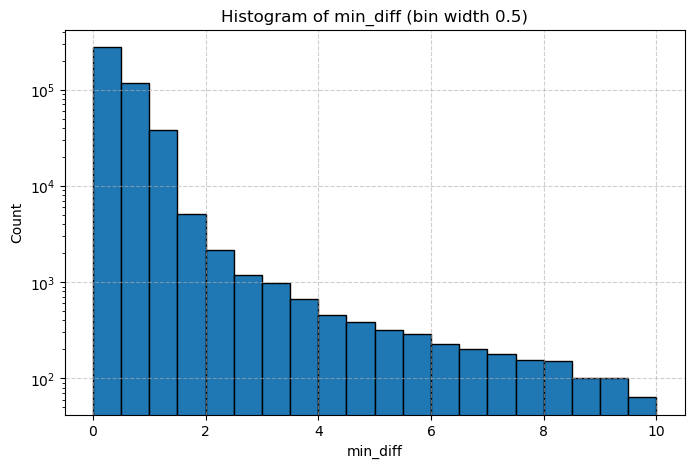

Number of deleted rows:  7155
Number of remaining rows:  438699


In [56]:
# Cleanup noise
every_throw_withpos_clean = every_throw_withpos

# Doing .groupby(["game_str","play_id","event_code"]) makes it only look at
#   the block with the same game_str, play_id, event_code
every_throw_withpos_clean['speed_above'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(1)
every_throw_withpos_clean['speed_below'] = every_throw_withpos_clean.groupby(
    ["game_str","play_id","event_code"])['prev_interval_ballspeed'].shift(-1)
every_throw_withpos_clean['diff_above'] = abs(every_throw_withpos_clean['speed_above'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['diff_below'] = abs(every_throw_withpos_clean['speed_below'] - every_throw_withpos_clean['prev_interval_ballspeed'])
every_throw_withpos_clean['min_diff'] = np.minimum(every_throw_withpos_clean['diff_above'], every_throw_withpos_clean['diff_below'])

# We're gonna get rid of all rows where its prev_interval_ballspeed value is 
#   more than ??? ft/s off compared to the row above & below

# Q. Shouldn't the ball always slow down? Why min_diff?
# A. Oh yeah, so if it's more than 2fps faster than next timestamp
#    (Since we're not considering bounces)

# According to drag calculations
# Over a 50 ms interval, a 100 mph baseball loses on the order of
# 0.5–0.9 m/s (≈ 1.5–3 fps) (≈ 1.2–2.0 mph) 

# Use a histogram to determine the ???
bins = np.arange(0, 10 + 0.5, 0.5)
plt.figure(figsize=(8, 5))
n, bins, patches = plt.hist(every_throw_withpos_clean['min_diff'], bins=bins, edgecolor='black')
plt.title('Histogram of min_diff (bin width 0.5)')
plt.xlabel('min_diff')
plt.ylabel('Count')
plt.grid(True, linestyle='--', alpha=0.6)
plt.yscale('log')  # log scale
plt.show()

# DECISION: 3.0 ft/s
display_df = every_throw_withpos_clean.copy()  # For display
display_df['delete'] = ((display_df['min_diff'] > 3.0))
deleted_rows = every_throw_withpos_clean[(display_df['min_diff'] > 3.0)]
# Keep row if min_diff <= 3.0 ft/s 
every_throw_withpos_clean = every_throw_withpos_clean[(display_df['min_diff'] <= 3.0)]
print(f"Number of deleted rows:  {len(deleted_rows)}")
print(f"Number of remaining rows:  {len(every_throw_withpos_clean)}")

# Drop used columns
every_throw_withpos_clean = every_throw_withpos_clean.drop(
    columns=["speed_above","speed_below","diff_above","diff_below",
             "latest_ball_pos_x","latest_ball_pos_y","latest_ball_pos_z",
             "min_diff","prev_timestamp"])
display_df = display_df[["game_str","play_id","player_position","event_code",
                         "timestamp","ball_pos_x_adj","ball_pos_y_adj","ball_pos_z_adj",
                         "ball_distance","prev_interval_ballspeed","min_diff","delete"]]
# # Display
# HTML(display_df.head(200)
#         .to_html(max_rows=200)
#         .replace('<table', '<div style="height:500px;overflow:auto;"><table')
#         .replace('</table>', '</table></div>'))

In [57]:
"""
Calculate momentum in direction to target
"""
# find the index of the max prev_interval_ballspeed in each group
idx = (every_throw_withpos_clean
      .groupby(["game_str","play_id","start_time","player_position","thrower_id","transition_ms"])["prev_interval_ballspeed"]
      .idxmax())
# select those rows (including ball_rad_xy)
max_speed_rows = every_throw_withpos_clean.loc[idx, 
    ['game_str','play_id','start_time','prev_interval_ballspeed','ball_rad_xy']]
max_speed_rows = max_speed_rows.rename(columns={"ball_rad_xy":"throwdir_rad"})

# Cosine projection
momdir = pd.merge(every_throw_withpos_clean,max_speed_rows,how="left",on=['game_str','play_id','start_time','prev_interval_ballspeed'])

momdir["momentum_inline_fps"] = (
    momdir["momentum_speed_fps"] * np.cos(momdir["momentum_angle_rad"] - momdir["throwdir_rad"]))

In [58]:
"""
Estimate max.velocities (i.e. "the" velo) of each throw
"""
every_throw_clean = momdir.groupby(
    ["game_str","play_id","start_time","player_position","thrower_id","transition_ms"]).agg(
        throw_fps = ('v0_dragadj','max'),
        momentum_inline_fps = ('momentum_inline_fps','max')
    ).reset_index()

# Convert the speeds to mph
every_throw_clean['throw_mph'] = every_throw_clean['throw_fps'] * 0.681818

every_throw_clean.head(5)

,game_str,play_id,start_time,player_position,thrower_id,transition_ms,throw_fps,momentum_inline_fps,throw_mph
0,y1_d001_CGA_QEA,2,31649,9,QEA-0252,2350,85.144942,5.399084,58.053354
1,y1_d001_CGA_QEA,4,88399,7,QEA-0249,1600,71.947752,1.787697,49.055273
2,y1_d001_CGA_QEA,17,444799,6,QEA-0027,850,109.647789,2.056008,74.759836
3,y1_d001_CGA_QEA,21,562499,5,QEA-0180,700,92.838894,9.132105,63.299229
4,y1_d001_CGA_QEA,21,563799,4,QEA-0365,650,95.527421,5.043676,65.132315


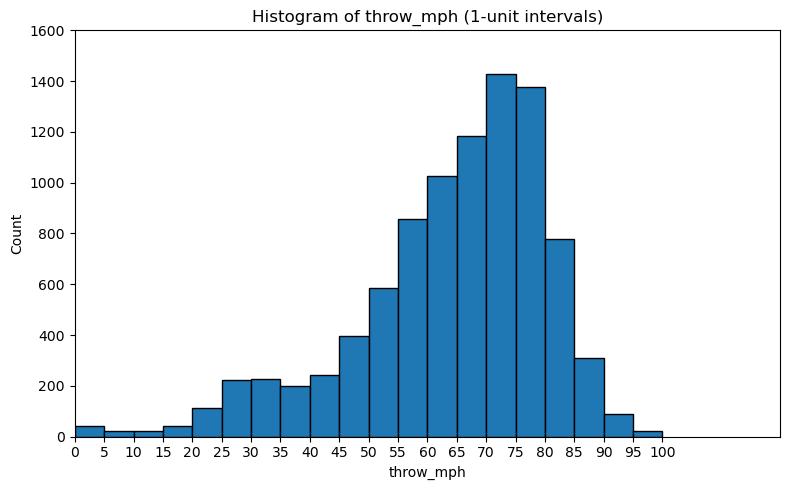

In [59]:
data = every_throw_clean['throw_mph'].dropna()

min_A = np.floor(data.min())
max_A = np.ceil(data.max())
bins = np.arange(min_A, max_A + 1, 5)

plt.figure(figsize=(8, 5))
plt.hist(data, bins=bins, edgecolor='black')
plt.xlabel('throw_mph')
plt.ylabel('Count')
plt.title('Histogram of throw_mph (1-unit intervals)')
plt.xticks(bins)
plt.xlim(0, 120)
plt.ylim(0, 1600)
plt.tight_layout()
plt.show()

In [60]:
"""
Make some charts
"""
def mode_func(x):
    # Return most common value; if tie, returns the first encountered
    return x.mode().iat[0] if not x.mode().empty else None

charting_df = every_throw_clean.groupby('thrower_id').agg(
    main_pos=('player_position', mode_func),
    max_mph=('throw_mph','max'),
    perc95_mph=('throw_mph', lambda x: x.quantile(0.95)),
    count=('throw_mph', 'size')).reset_index() 

def selective_top_mean(group):
    pos = mode_func(group['player_position'])
    x = group['throw_mph']
    n = len(x)
    # Select percentage based on position
    if pos in (3,4,5,6):
        pct = 0.05
    elif pos in (7, 8, 9, 2):
        pct = 0.10
    else:
        pct = 0.01
    k = max(int(np.ceil(pct * n)), 1)
    return x.nlargest(k).mean()
selective_top_mean = every_throw_clean.groupby('thrower_id').apply(selective_top_mean).rename('statcast_mph')
charting_df = charting_df.merge(selective_top_mean, left_on='thrower_id', right_index=True)

def qualified_indices(group):
    pos = mode_func(group['player_position'])
    n = len(group)
    # Select percentage based on position
    if pos in (3,4,5,6):
        pct = 0.05
    elif pos in (7,8,9,2):
        pct = 0.10
    else:
        pct = 0.01
    k = max(int(np.ceil(pct * n)), 1)
    qualified = group.nlargest(k, 'throw_mph')
    return qualified.index  # Return indices of qualified throws
qualified_throw_indices = every_throw_clean.groupby('thrower_id').apply(qualified_indices)
qualified_idx = np.concatenate(qualified_throw_indices.values)
qualified_throws = every_throw_clean.loc[qualified_idx]
# Mode transition (qualified)
qualified_mode_transition = qualified_throws.groupby('thrower_id')['transition_ms'].agg(mode_func).rename('mode_transition_ms')
charting_df = charting_df.merge(qualified_mode_transition, left_on='thrower_id', right_index=True)
# Mode momentum (qualified)
qualified_mode_momentum = qualified_throws.groupby('thrower_id')['momentum_inline_fps'].agg(mode_func).rename('mode_momentum_fps')
charting_df = charting_df.merge(qualified_mode_momentum, left_on='thrower_id', right_index=True)

# Rename main position
conditions = [
    charting_df['main_pos'] == 1,    charting_df['main_pos'] == 2,    charting_df['main_pos'] == 3,    charting_df['main_pos'] == 4,
    charting_df['main_pos'] == 5,    charting_df['main_pos'] == 6,    charting_df['main_pos'] == 7,    charting_df['main_pos'] == 8,    charting_df['main_pos'] == 9
]
choices = [
    'pitcher','catcher','first_base','second_base','third_base','shortstop',
    'left_field','center_field','right_field'
]
charting_df['main_pos'] = np.select(conditions, choices, default=None)

# Sort
charting_df = charting_df.sort_values(by='statcast_mph', ascending=False).reset_index(drop=True)
HTML(charting_df.head(100)
        .to_html(max_rows=100)
        .replace('<table', '<div style="height:500px;overflow:auto;"><table')
        .replace('</table>', '</table></div>'))

C:\Users\mla21\AppData\Local\Temp\ipykernel_5448\1931514614.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  selective_top_mean = every_throw_clean.groupby('thrower_id').apply(selective_top_mean).rename('statcast_mph')
C:\Users\mla21\AppData\Local\Temp\ipykernel_5448\1931514614.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  qualified_throw_indices = every_throw_clean.groupby('thrower_id').apply(qu

,thrower_id,main_pos,max_mph,perc95_mph,count,statcast_mph,mode_transition_ms,mode_momentum_fps
0,AKX-1254,center_field,102.969964,95.121066,9,102.969964,1000,3.042767
1,NYA-2485,center_field,100.023313,93.659436,7,100.023313,1150,10.228623
2,JZK-1356,right_field,99.304314,97.959009,7,99.304314,1050,2.564313
3,UKI-2288,shortstop,98.865326,90.151975,11,98.865326,950,8.041216
4,UPU-2318,left_field,98.730855,97.089586,2,98.730855,1550,2.763134
5,XAX-2387,left_field,98.618939,96.562711,8,98.618939,1050,4.962679
6,UPU-1731,right_field,98.023980,94.672582,10,98.023980,850,3.024773
7,YUH-1918,right_field,97.017398,96.898622,7,97.017398,1100,7.167346
8,HCI-2523,left_field,96.060827,95.607841,8,96.060827,900,5.858096
9,VZE-2173,shortstop,96.037707,95.660882,3,96.037707,627,1.949521


In [61]:
# Visualize better
(
    # Convert to a great-table
    gt.GT(charting_df.head(20))
    # Title/Subtitle
    .tab_header(title = "Top 20 Arms")
    # Format columns to a certain number of decimal points
    .fmt_number(columns = ["statcast_mph", "mode_momentum_fps"], decimals = 2)
    .fmt_number(columns = ["max_mph", "perc95_mph", "count"], decimals = 1)
    .fmt_number(columns = ["count"], decimals=0)
    # Rename columns for the table
    .cols_label(
        thrower_id = "thrower_id",
        max_mph = "Max velo (mph)",
        perc95_mph = "95th percentile",
        count = "Count"
    )
    # Align all columns to center
    .cols_align("center")
    # Color rows with outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.fill(color="#092C5C"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Make text color white for outfielders
    .tab_style(
    # How to style the cells
    style = gt.style.text(color="white"),
    # Which cells to style
    locations = gt.loc.body(columns = "main_pos",
                           rows = [0,1,3,4,6,8,9,10,11,13,14,15,16,18,19])
    )
    # Color rows with infielders
    .tab_style(
    style = gt.style.fill(color="#8FBCE6"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [2])
    )
    # Color Rows with others
    .tab_style(
    style = gt.style.fill(color="#F5D130"),
    locations = gt.loc.body(columns = "main_pos",
                           rows = [5,7,12,17])
    )
    # # To save the table
    # .save("Top-20-Arms.png")
)

GT(_tbl_data=   thrower_id      main_pos     max_mph  perc95_mph  count  statcast_mph  \
0    AKX-1254  center_field  102.969964   95.121066      9    102.969964   
1    NYA-2485  center_field  100.023313   93.659436      7    100.023313   
2    JZK-1356   right_field   99.304314   97.959009      7     99.304314   
3    UKI-2288     shortstop   98.865326   90.151975     11     98.865326   
4    UPU-2318    left_field   98.730855   97.089586      2     98.730855   
5    XAX-2387    left_field   98.618939   96.562711      8     98.618939   
6    UPU-1731   right_field   98.023980   94.672582     10     98.023980   
7    YUH-1918   right_field   97.017398   96.898622      7     97.017398   
8    HCI-2523    left_field   96.060827   95.607841      8     96.060827   
9    VZE-2173     shortstop   96.037707   95.660882      3     96.037707   
10   DYE-0089  center_field   97.758021   94.877580     30     95.779487   
11   VZE-1476   right_field   95.701809   88.179159      9     95.701809   
12   APZ-2380   right_field   96.532044   95.058737     11     95.058737   
13   WMI-2030   right_field   94.833515   91.625413      8     94.833515   
14   KNB-2032    third_base   94.378985   89.574862      9     94.378985   
15   JIL-1994  center_field   96.240045   93.379799     15     94.197012   
16   OXG-0396  center_field   94.182469   87.514787      6     94.182469   
17   IAK-1871   right_field   93.604672   88.333771      8     93.604672   
18   AVV-1174  center_field   93.549038   90.595401      4     93.549038   
19   IKJ-2099   right_field   94.559878   93.350640     12     93.460570   

    mode_transition_ms  mode_momentum_fps  
0                 1000           3.042767  
1                 1150          10.228623  
2                 1050           2.564313  
3                  950           8.041216  
4                 1550           2.763134  
5                 1050           4.962679  
6                  850           3.024773  
7                 1100           7.167346  
8                  900           5.858096  
9                  627           1.949521  
10                1000           1.572725  
11                 891          12.489072  
12                1200           6.008427  
13                 950           4.255601  
14                1122           5.289387  
15                1000           7.413934  
16                 950          11.293371  
17                1254           2.741324  
18                1023          13.056801  
19                1050           4.799682  , _body=<great_tables._gt_data.Body object at 0x0000026158B24590>, _boxhead=Boxhead([ColInfo(var='thrower_id', type=<ColInfoTypeEnum.default: 1>, column_label='thrower_id', column_align='center', column_width=None), ColInfo(var='main_pos', type=<ColInfoTypeEnum.default: 1>, column_label='main_pos', column_align='center', column_width=None), ColInfo(var='max_mph', type=<ColInfoTypeEnum.default: 1>, column_label='Max velo (mph)', column_align='center', column_width=None), ColInfo(var='perc95_mph', type=<ColInfoTypeEnum.default: 1>, column_label='95th percentile', column_align='center', column_width=None), ColInfo(var='count', type=<ColInfoTypeEnum.default: 1>, column_label='Count', column_align='center', column_width=None), ColInfo(var='statcast_mph', type=<ColInfoTypeEnum.default: 1>, column_label='statcast_mph', column_align='center', column_width=None), ColInfo(var='mode_transition_ms', type=<ColInfoTypeEnum.default: 1>, column_label='mode_transition_ms', column_align='center', column_width=None), ColInfo(var='mode_momentum_fps', type=<ColInfoTypeEnum.default: 1>, column_label='mode_momentum_fps', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000026107E835C0>, _spanners=Spanners([]), _heading=Heading(title='Top 20 Arms', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname=LocBody(columns='main_pos', rows=[0, 1, 3, 4, 6, 8, 9, 10, 11, 13, 14, 